In [1]:
import heapq
import requests as req
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import scipy as sp
import statsmodels.api as sm
from scipy import fftpack
from scipy import interpolate
from scipy import signal
from scipy import stats
from sortedcontainers import SortedDict as sd
from collections import Counter

%matplotlib inline

In [2]:
ROOT = 'http://localhost:8080/argusws'
with open('.login.txt') as login:
    username = login.readline().rstrip()
    password = login.readline().rstrip()
login_info = json.dumps({'username':username, 'password':password})
headers = {'content-type':'application/json'}

In [3]:
auth = req.post(ROOT + '/auth/login', data=login_info, headers=headers)
cookies = auth.cookies

In [4]:
r = req.get(ROOT + '/metrics?expression=-5d:argus.jvm:mem.heap.used:avg', headers=headers, cookies=cookies)
data = sd(r.json()[0]['datapoints'])

In [6]:
keys = [int(key) for key in data.keys()]
diff_counts = Counter([keys[i+1] - keys[i] for i in range(len(keys)-1)])
values = [float(data[key]) for key in sorted(data.keys())]

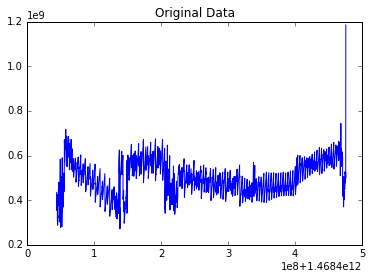

In [7]:
def plot_original_data(keys, values):
    plt.plot(keys, values)
    plt.title('Original Data')
    plt.show()
plot_original_data(keys, values)

In [ ]:
def get_data(filename):
    df = pd.read_csv(filename, skipfooter=3)
    data = df.iloc[:-1, 1]
    data = [float(num) for num in data]
    times = [i for i in range(len(data))]
    return times, data

In [ ]:
def most_common_diff(lst):
    diffs = [lst[i+1] - lst[i] for i in range(len(lst) - 1)]
    return Counter(diffs).most_common(1)[0][1]

In [ ]:
def fill_interpolate(time, values):
    f = interpolate.interp1d(time, values)
    norm_times = [i for i in range(time[0], time[-1], most_common_diff(time))]
    print(Counter([norm_times[i+1] - norm_times[i] for i in range(len(norm_times) - 1)]))
    return norm_times, f(norm_times)

In [ ]:
def wavelet_anomaly(time, values, wavelet='db2'):
    cA, cD = pywt.dwt(values, wavelet)
    approx = pywt.idwt(cA, np.zeros((len(cD,))), wavelet)
    if len(values) != len(approx):
        approx = approx[:-1]
    
    plt.plot(time, values)
    plt.title('Original Data with Anomaly')
    plt.savefig('original anomaly.png')
    plt.close()
    
    resid = values - approx

    plt.plot(time, approx)
    plt.title('Approximation')
    plt.savefig('approximation.png')
    plt.close()

    plt.plot(time, 10*np.abs(resid))
    plt.title('Residuals')
    plt.savefig('residuals.png')
    plt.close()
    return resid

In [ ]:
def gaussian_pdf(resid):
    mean = np.mean(resid)
    std = np.std(resid)
    gaussian = (1 - stats.norm.pdf((resid - [mean]*len(resid))/std)/stats.norm.pdf(0))
    return gaussian

In [ ]:
def symmetric_anomaly_graph(filename):
    times, data = get_data(filename)
    plot_original_data(times, data)
    resid = wavelet_anomaly(times, data)
    gauss = gaussian_pdf(resid)
    plt.plot(times, gauss)
    plt.title('Gaussian Values')
    plt.show()
    return times, resid

def anomaly_graph(times, data):
    resid = wavelet_anomaly(times, data)
    gauss = gaussian_pdf(resid)
    plt.plot(times, gauss)
    plt.title('Gaussian Values')
    plt.show()
    return times, resid

In [ ]:
def fft_components(time_series_dict):
    keys = sorted(time_series_dict.keys())
    values = [time_series_dict[key] for key in keys]
    components = np.fft.rfft(values)
    return components

def fft_components(times, values):
    components = np.fft.rfft(values)
    return components

In [ ]:
real_keys = keys
real_vals = values
for wavelet in pywt.wavelist():
    wavelet_anomaly(keys, values, wavelet)
# resid = wavelet_anomaly(keys, values)
# gauss = gaussian_pdf(resid)
# plt.plot(keys, gauss)

In [ ]:
milk_data = pd.read_csv('/Users/vmuruganantham/Downloads/monthly-milk-production-pounds-p.csv')

In [ ]:
milk_vals = milk_data.iloc[:,1]
milk_times = [i for i in range(len(milk_vals))]

In [ ]:
milk_resid = wavelet_anomaly(milk_times, milk_vals)

In [ ]:
wolfer_data = pd.read_csv('/Users/vmuruganantham/Downloads/wolfer-sunspot-numbers-1770-to-1.csv').iloc[:-1,1]
wolfer_data = [int(num) for num in wolfer_data]
wolfer_times = [i for i in range(len(wolfer_data))]

In [ ]:
wavelet_anomaly(wolfer_times, wolfer_data)

In [ ]:
# symmetric_anomaly_graph('/Users/vmuruganantham/Downloads/co2-ppm-mauna-loa-19651980.csv')
times, data = get_data('/Users/vmuruganantham/Downloads/co2-ppm-mauna-loa-19651980.csv')
new_data = data[:len(data)//2]
new_data += [data[i] - np.mean(data)/25 for i in range(len(data)//2, 2*len(data)//3)]
new_data += data[2*len(data)//3:]
anomaly_graph(times, data)

In [ ]:
filled_times, filled_vals = fill_interpolate(keys, values)

In [ ]:
N = len(filled_times)
T = filled_times[1] - filled_times[0]
frq = np.arange(N)/(N/(1/27419))
frq = frq[range(int(N/2))]
y = np.fft.fft(filled_vals)/N
y = y[range(int(N/2))]

In [ ]:
plt.plot(frq, abs(y), 'o')
plt.show()

In [ ]:
times, data = get_data('/Users/vmuruganantham/Downloads/internet-traffic-data-in-bits-fr.csv')
new_data = data[:len(data)//2]
new_data += [data[i] + np.mean(data) for i in range(len(data)//2, 2*len(data)//3)]
new_data += data[2*len(data)//3:]
anomaly_graph(times, new_data)
# times, data = symmetric_anomaly_graph('/Users/vmuruganantham/Downloads/internet-traffic-data-in-bits-fr.csv')

In [ ]:
times, data = anomaly_graph(times, data)

In [ ]:
symmetric_anomaly_graph('/Users/vmuruganantham/Downloads/monthly-car-sales-in-quebec-1960.csv')

In [ ]:
x = np.tile(np.arange(0,2*np.pi, np.pi/100), 500)
y = np.tile((x+np.pi/2) % np.pi - np.pi/2, 500)
plt.plot(y)
plt.show()
spectral = np.fft.rfft(y)/len(y)
spectral = spectral[range(len(y)//2)]
plt.plot(abs(spectral))

In [ ]:
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
freq = np.linspace(1e3, 2e3, N)
x = amp * np.sin(2*np.pi*freq*time)
# x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
# plt.plot(x[:1000])
# plt.show()
f, t, Sxx = signal.spectrogram(y, fs)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [ ]:
times, values = get_data('/Users/vmuruganantham/Downloads/co2-ppm-mauna-loa-19651980.csv')
f = np.linspace(1, len(times), 10)
# lspgram = sp.signal.lombscargle(np.ndarray(times), np.ndarray(values), f)
# plt.plot(f, np.sqrt(4*(lspgram/len(times))))

In [ ]:
ecg = pywt.data.ecg()
plt.plot(ecg)
plt.title('Original Data without Anomaly')
plt.savefig('original no anomaly.png')
plt.close()
newecg = np.concatenate((ecg[:300], [i - 20 for i in ecg[300:350]], ecg[350:]))
wavelet_anomaly([i for i in range(len(newecg))], newecg, 'db20')
# plt.plot(pywt.downcoef('d', newecg, 'db20'))
# plt.show()
# wavelet_anomaly([i for i in range(len(newecg))], newecg, 'db20')
# plt.plot([i for i in range(len(newecg))], newecg)
# plt.show()

In [ ]:
data = sm.datasets.co2.load_pandas().data
data.co2.interpolate(inplace=True)

real_data = pd.DataFrame(data = real_vals, index = real_keys, columns = ['heap'])
real_data.heap.interpolate(inplace=True)

In [ ]:
res = sm.tsa.seasonal_decompose(data)
res.plot()
plt.plot(res.resid)

In [13]:
formatted_X = [[[values[i]], [values[i+1]], [values[i+2]], [values[i+3]], [values[i+4]]] for i in range(0, len(values)-5)]
formatted_y = [[values[i+5]] for i in range(0, len(values)-5)]